In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

import utils
import constants

In [38]:
def drop_and_fill(data):
    data["timestamp"] = pd.to_datetime(data["timestamp"])
    data = data.drop(["QGL", "T-JUS-CKGL"], axis=1)
    data = data.fillna(0)
    data = data.set_index("timestamp")
    
    return data

In [51]:
train_df = pd.DataFrame()

### Generate training dataset

Add normal sequences

In [52]:
train_normal, test_normal = utils.read_files(constants.FILE_PATH, classes=[constants.NORMAL_CLASS], real_only=True, test_size=0.5)

for file in tqdm(train_normal[:15]):
    data = pd.read_csv(file)
    data = drop_and_fill(data)
    data = data.drop("class", axis=1)
    n_sequences = len(data) // constants.STEPS
    data = data.iloc[:n_sequences*constants.STEPS]
    train_df = pd.concat([train_df, data])

100%|██████████| 15/15 [00:01<00:00,  8.54it/s]


Add normal sequences from abnormal files

In [53]:
train_abnormal, test_abnormal = utils.read_files(constants.FILE_PATH, classes=constants.ABNORMAL_CLASSES, real_only=True, test_size=0.5)

for file in tqdm(train_abnormal):
    data = pd.read_csv(file)
    data = drop_and_fill(data)

    # Get normal sequence
    data = data[data["class"] == 0]
    
    data = data.drop("class", axis=1)
    n_sequences = len(data) // constants.STEPS
    data = data.iloc[:n_sequences*constants.STEPS]
    train_df = pd.concat([train_df, data])

100%|██████████| 25/25 [00:04<00:00,  6.14it/s]


In [54]:
# Store until when there are normal samples to create y_train later
normal_samples = len(train_df) / constants.STEPS

Add anomaly sequences

In [55]:
for file in tqdm(train_abnormal):
    data = pd.read_csv(file)
    data = drop_and_fill(data)

    # Get abnormal sequence
    data = data[data["class"] != 0]
    
    data = data.drop("class", axis=1)
    n_sequences = len(data) // constants.STEPS
    data = data.iloc[:n_sequences*constants.STEPS]
    train_df = pd.concat([train_df, data])

100%|██████████| 25/25 [00:04<00:00,  6.02it/s]


In [56]:
train_df = train_df.reset_index(drop=True)

Text(0.5, 1.0, 'After')

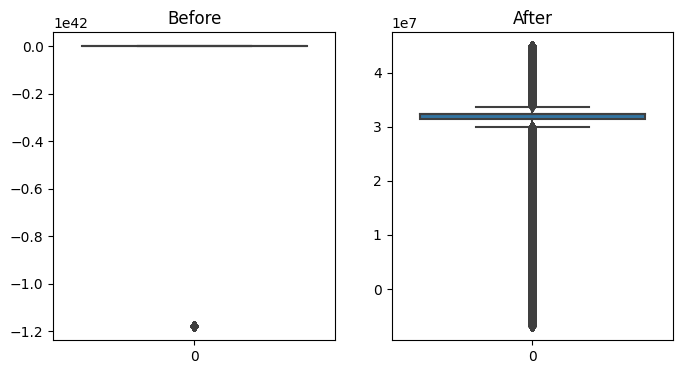

In [57]:
f, ax = plt.subplots(ncols=2, figsize=(8, 4))
sns.boxplot(train_df["P-PDG"], ax=ax[0])
sns.boxplot(train_df[train_df["P-PDG"] > -0.5*1e42]["P-PDG"], ax=ax[1])

ax[0].set_title("Before")
ax[1].set_title("After")

In [58]:
# Removing extreme outliers to improve standardization
train_df = train_df[train_df["P-PDG"] > -0.5*1e42]

In [61]:
scaler = StandardScaler()
train = scaler.fit_transform(train_df)

In [62]:
train_sequences = utils.create_sequence(train)

In [64]:
x_train = np.empty(shape=(0, 5, 6))

for seq in tqdm(train_sequences):
    s_features = utils.get_features(seq).reshape((1, 5, 6))
    x_train = np.concatenate((x_train, s_features))

x_train = x_train.reshape(x_train.shape[0], 30)
y_train = [0 if i < normal_samples else 1 for i in range(len(x_train))]

100%|██████████| 12809/12809 [00:11<00:00, 1154.42it/s]


In [66]:
# Normal class ratio
normal_samples / len(x_train)

0.4652978374580373

In [65]:
print("k | Mean | Std")
print("--------------")

for k in range(1, 30, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=k)
    scores = cross_val_score(knn, x_train, y_train, cv=skf, scoring="f1")
    print(f"{str(k).zfill(2)}  {scores.mean():.2f}  {scores.std():.2f}")

k | Mean | Std
--------------
01  0.99  0.00
03  0.99  0.00
05  0.99  0.00
07  0.99  0.00
09  0.99  0.00
11  0.99  0.00
13  0.99  0.00
15  0.99  0.00
17  0.99  0.00
19  0.99  0.00
21  0.98  0.00
23  0.98  0.00
25  0.98  0.00
27  0.98  0.00
29  0.98  0.00


### Test

In [16]:
test_data = pd.read_csv(test_abnormal[3])
test_data = drop_and_fill(test_data)
test_data = test_data.drop("class", axis=1)
test_data_preprocessed = scaler.transform(test_data)

test_sequences = utils.create_sequence(test_data_preprocessed)

x_test = np.empty(shape=(0, 5, 6))

for seq in test_sequences:
    s_features = utils.get_features(seq).reshape((1, 5, 6))
    x_test = np.concatenate((x_test, s_features))

x_test = x_test.reshape(x_test.shape[0], 30)

In [17]:
preds = knn.predict(x_test)
preds = np.repeat(preds, constants.STEPS)

# Remove leftover out of sequences
test_data = test_data.iloc[:len(preds)]

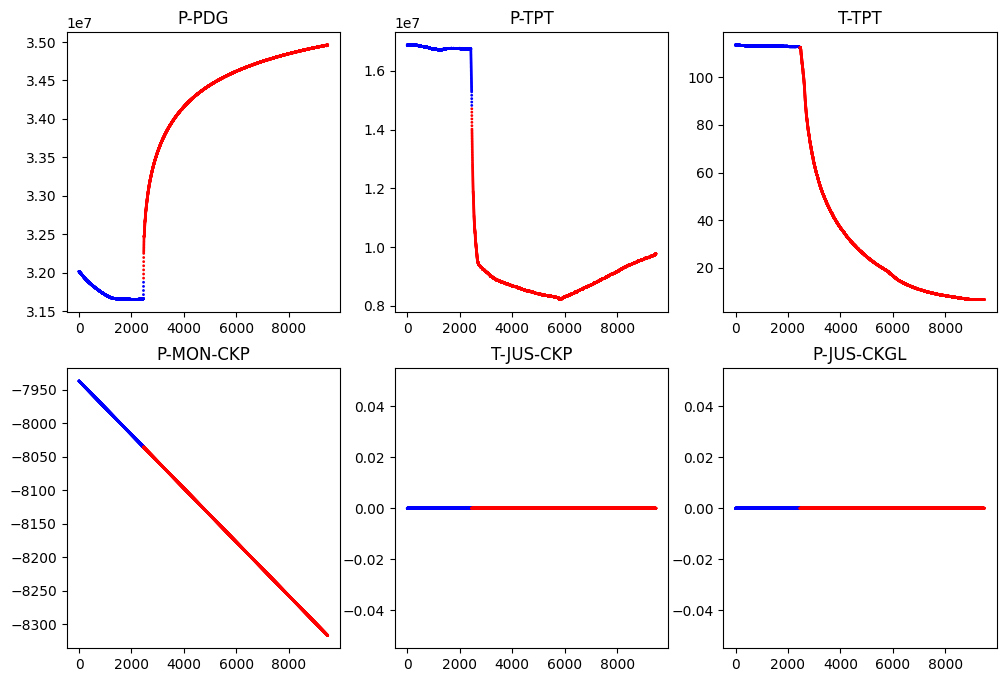

In [18]:
rows = 2
cols = 3

f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))

columns = test_data.columns

# Normal = Blue
# Anomaly = Red
colors = ["blue" if pred == 0 else "red" for pred in preds]

for i in range(rows):
    for j in range(cols):
        ax[i][j].scatter(x=range(len(test_data)), y=test_data[columns[i*(rows+1) + j]].values, c=colors, s=1)
        ax[i][j].set_title(columns[i*(rows+1) + j])